In [ ]:
from selenium import webdriver
import pandas as pd
from bs4 import BeautifulSoup
import time; time.sleep(5)
from io import StringIO
from decimal import Decimal, getcontext
import numpy as np
from scipy.stats import shapiro
from scipy.stats import lognorm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [249]:
import xlsxwriter

# Importing Data Tables From Goonhammer

In [8]:
url_dict = {
    "winPCT_faction" : "https://40kstats.goonhammer.com/#GbF",
    "scoring_faction" : "https://40kstats.goonhammer.com/#SbF",
    "mission_scoring" : "https://40kstats.goonhammer.com/#Ps"
}

In [9]:
def fetch_tables(url_dict, wait_time=5):
    results = {}

    for name, url in url_dict.items():
        print(f"Fetching: {name} from {url}")
        
        # Start WebDriver
        driver = webdriver.Chrome()
        driver.get(url)

        # Wait for JavaScript content to load
        time.sleep(wait_time)

        # Parse HTML
        soup = BeautifulSoup(driver.page_source, "html.parser")
        html_io = StringIO(str(soup))
        tables = pd.read_html(html_io)

        driver.quit()

        # Store first table in dictionary with the given name
        results[name] = tables[0]

    return results

In [10]:
dataframes = fetch_tables(url_dict)

Fetching: winPCT_faction from https://40kstats.goonhammer.com/#GbF
Fetching: scoring_faction from https://40kstats.goonhammer.com/#SbF
Fetching: mission_scoring from https://40kstats.goonhammer.com/#Ps


In [11]:
winPCT_faction_df = dataframes["winPCT_faction"]
scoring_faction_df = dataframes["scoring_faction"]
mission_scoring_df = dataframes["mission_scoring"]

# Checking Data Quality

In [12]:
def quality(df):
    print("Shape:", df.shape)
    print("\nColumn Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nDuplicate Rows:", df.duplicated().sum())
    print("\nBasic Stats:\n", df.describe(include='all'))

In [69]:
quality(winPCT_faction_df)

Shape: (28, 9)

Column Types:
 Faction       object
Games         object
VP            object
Opp VP        object
Win %         object
Wins          object
Losses        object
Draws         object
Real Win %    object
dtype: object

Missing Values:
 Faction       0
Games         0
VP            0
Opp VP        0
Win %         0
Wins          0
Losses        0
Draws         0
Real Win %    0
dtype: int64

Duplicate Rows: 0

Basic Stats:
                  Faction Games     VP Opp VP  Win % Wins Losses Draws  \
count                 28    28     28     28     28   28     28    28   
unique                28    28     28     28     28   28     27    23   
top     Adepta Sororitas  1915  64.02  61.04  48.93  937   1691    33   
freq                   1     1      1      1      1    1      2     2   

       Real Win %  
count          28  
unique         28  
top         48.92  
freq            1  


In [68]:
quality(scoring_faction_df)

Shape: (28, 8)

Column Types:
 Faction                          object
Player Primary                  float64
Player Tactical                 float64
Player Fixed                    float64
Opponent Primary                float64
Opponent Tactical               float64
Opponent Fixed                  float64
Primary Scoring Differential    float64
dtype: object

Missing Values:
 Faction                         0
Player Primary                  0
Player Tactical                 0
Player Fixed                    0
Opponent Primary                0
Opponent Tactical               0
Opponent Fixed                  0
Primary Scoring Differential    0
dtype: int64

Duplicate Rows: 0

Basic Stats:
                  Faction  Player Primary  Player Tactical  Player Fixed  \
count                 28       28.000000        28.000000     28.000000   
unique                28             NaN              NaN           NaN   
top     Adepta Sororitas             NaN              NaN           NaN  

In [15]:
quality(mission_scoring_df)

Shape: (70, 9)

Column Types:
 Mission         object
Deployment      object
Games            int64
Avg, Winner    float64
Avg, Loser     float64
Margin         float64
Avg, Go 1st    float64
Avg, Go 2nd    float64
FTA            float64
dtype: object

Missing Values:
 Mission        0
Deployment     0
Games          0
Avg, Winner    0
Avg, Loser     0
Margin         0
Avg, Go 1st    0
Avg, Go 2nd    0
FTA            0
dtype: int64

Duplicate Rows: 0

Basic Stats:
                 Mission Deployment        Games  Avg, Winner  Avg, Loser  \
count                70         70    70.000000    70.000000   70.000000   
unique               10          7          NaN          NaN         NaN   
top     Burden Of Trust  All Games          NaN          NaN         NaN   
freq                  7         10          NaN          NaN         NaN   
mean                NaN        NaN  1070.028571    35.014429   18.659143   
std                 NaN        NaN  1639.997578     4.694083    5.904798  

# Cleanup & Transformations

In [16]:
winPCT_faction_df["Win %"] = winPCT_faction_df["Win %"].str.replace('%', '').astype('float64')

In [17]:
scoring_faction_df['Faction'] = scoring_faction_df['Faction'].astype(str)

In [18]:
scoring_faction_df = scoring_faction_df.loc[:, ~scoring_faction_df.columns.str.contains('^Unnamed', na=False)]

In [19]:
mission_scoring_df['Mission'] = mission_scoring_df['Mission'].astype(str)
mission_scoring_df['Deployment'] = mission_scoring_df['Deployment'].astype(str)

In [65]:
# Function to convert a value to Decimal, to ensure precision in calculating derived columns
def to_decimal(val):
    return Decimal(str(val))

In [88]:
#Change floats to decimals for all dfs
numeric_cols = winPCT_faction_df.select_dtypes(include=["float64", "int64"]).columns
for col in numeric_cols:
    winPCT_faction_df[col] = winPCT_faction_df[col].apply(to_decimal)

numeric_cols = scoring_faction_df.select_dtypes(include=["float64", "int64"]).columns
for col in numeric_cols:
    scoring_faction_df[col] = scoring_faction_df[col].apply(to_decimal)

numeric_cols = mission_scoring_df.select_dtypes(include=["float64", "int64"]).columns
for col in numeric_cols:
    mission_scoring_df[col] = mission_scoring_df[col].apply(to_decimal)

In [72]:
#Adding Primary and seccondary differential to faction scoring df

scoring_faction_df['Primary Scoring Differential'] = scoring_faction_df['Player Primary'] - scoring_faction_df['Opponent Primary']

scoring_faction_df['Tactical Scoring Differential'] = scoring_faction_df['Player Tactical'] - scoring_faction_df['Opponent Tactical']

scoring_faction_df['Fixed Scoring Differential'] = scoring_faction_df['Player Fixed'] - scoring_faction_df['Opponent Fixed']

In [92]:
# Change decimal columns back to float for plotting

for col in winPCT_faction_df.columns:
    if isinstance(winPCT_faction_df[col].iloc[0], Decimal):
        winPCT_faction_df[col] = winPCT_faction_df[col].apply(float)

for col in scoring_faction_df.columns:
    if isinstance(scoring_faction_df[col].iloc[0], Decimal):
        scoring_faction_df[col] = scoring_faction_df[col].apply(float)

for col in mission_scoring_df.columns:
    if isinstance(mission_scoring_df[col].iloc[0], Decimal):
        mission_scoring_df[col] = mission_scoring_df[col].apply(float)

In [105]:
# Check dytpes
allowed_types = ["int64", "float64"]
obj_cols = ["Faction", "Mission", "Deployment"]

def validate_column_dtypes(df, allowed_dtypes, excluded_cols=None):
    if excluded_cols is None:
        excluded_cols = []

    for col, dtype in df.dtypes.items():
        if col in excluded_cols:
            continue  # Skip excluded columns
        if str(dtype) not in allowed_dtypes:
            raise TypeError(f"Column '{col}' has unexpected dtype: {dtype}")
        else :
            print(f"Column '{col}' has expected dtype: {dtype}")

In [106]:
validate_column_dtypes(winPCT_faction_df, allowed_types, excluded_cols=obj_cols)

Column 'Games' has expected dtype: float64
Column 'VP' has expected dtype: float64
Column 'Opp VP' has expected dtype: float64
Column 'Win %' has expected dtype: float64
Column 'Wins' has expected dtype: float64
Column 'Losses' has expected dtype: float64
Column 'Draws' has expected dtype: float64
Column 'Real Win %' has expected dtype: float64


In [107]:
validate_column_dtypes(scoring_faction_df, allowed_types, excluded_cols=obj_cols)

Column 'Player Primary' has expected dtype: float64
Column 'Player Tactical' has expected dtype: float64
Column 'Player Fixed' has expected dtype: float64
Column 'Opponent Primary' has expected dtype: float64
Column 'Opponent Tactical' has expected dtype: float64
Column 'Opponent Fixed' has expected dtype: float64
Column 'Primary Scoring Differential' has expected dtype: float64
Column 'Tactical Scoring Differential' has expected dtype: float64
Column 'Fixed Scoring Differential' has expected dtype: float64


In [108]:
validate_column_dtypes(mission_scoring_df, allowed_types, excluded_cols=obj_cols)

Column 'Games' has expected dtype: float64
Column 'Avg, Winner' has expected dtype: float64
Column 'Avg, Loser' has expected dtype: float64
Column 'Margin' has expected dtype: float64
Column 'Avg, Go 1st' has expected dtype: float64
Column 'Avg, Go 2nd' has expected dtype: float64
Column 'FTA' has expected dtype: float64


In [113]:
#Creating new scorewin df so that I can work with win rates and scoring from one df
scorewin = pd.merge(scoring_faction_df, winPCT_faction_df[["Faction", "VP", "Opp VP", "Real Win %"]], on="Faction", how="left")

In [114]:
scorewin = scorewin.rename(columns={"Real Win %": "Win Percentage"})

Questions:

    Does a higher primary/secondary score/drif corelate with higher winrate?
    Can we use a linear/multiple regression model to check if primary/secondary scores are predictive of win-rate, and if so is one more important than the other?
    If so can we predict a winrate based on primary or score diffs?

# Normality Testing

In [20]:
def check_normality(df, alpha=0.05):
    for col in df.select_dtypes(include='number').columns:
        data = df[col].dropna()
        if len(data) < 3:
            print(f"{col}: Not enough data for Shapiro test")
            continue
        stat, p = shapiro(data)
        if p > alpha:
            print(f"{col}:  Normally distributed (p = {p:.4f})")
        else:
            print(f"{col}:  Not normal (p = {p:.4f})")

In [109]:
check_normality(winPCT_faction_df)

Games:  Normally distributed (p = 0.7972)
VP:  Normally distributed (p = 0.9062)
Opp VP:  Normally distributed (p = 0.1450)
Win %:  Normally distributed (p = 0.1254)
Wins:  Normally distributed (p = 0.2701)
Losses:  Normally distributed (p = 0.8298)
Draws:  Normally distributed (p = 0.4755)
Real Win %:  Normally distributed (p = 0.1227)


In [110]:
check_normality(scoring_faction_df)

Player Primary:  Normally distributed (p = 0.1487)
Player Tactical:  Normally distributed (p = 0.6307)
Player Fixed:  Normally distributed (p = 0.4741)
Opponent Primary:  Normally distributed (p = 0.0927)
Opponent Tactical:  Not normal (p = 0.0408)
Opponent Fixed:  Normally distributed (p = 0.1998)
Primary Scoring Differential:  Normally distributed (p = 0.0896)
Tactical Scoring Differential:  Normally distributed (p = 0.0847)
Fixed Scoring Differential:  Normally distributed (p = 0.8125)


In [111]:
check_normality(mission_scoring_df)

Games:  Not normal (p = 0.0000)
Avg, Winner:  Not normal (p = 0.0241)
Avg, Loser:  Normally distributed (p = 0.1215)
Margin:  Not normal (p = 0.0204)
Avg, Go 1st:  Not normal (p = 0.0082)
Avg, Go 2nd:  Normally distributed (p = 0.3687)
FTA:  Not normal (p = 0.0002)


# Initial Data Visualisation

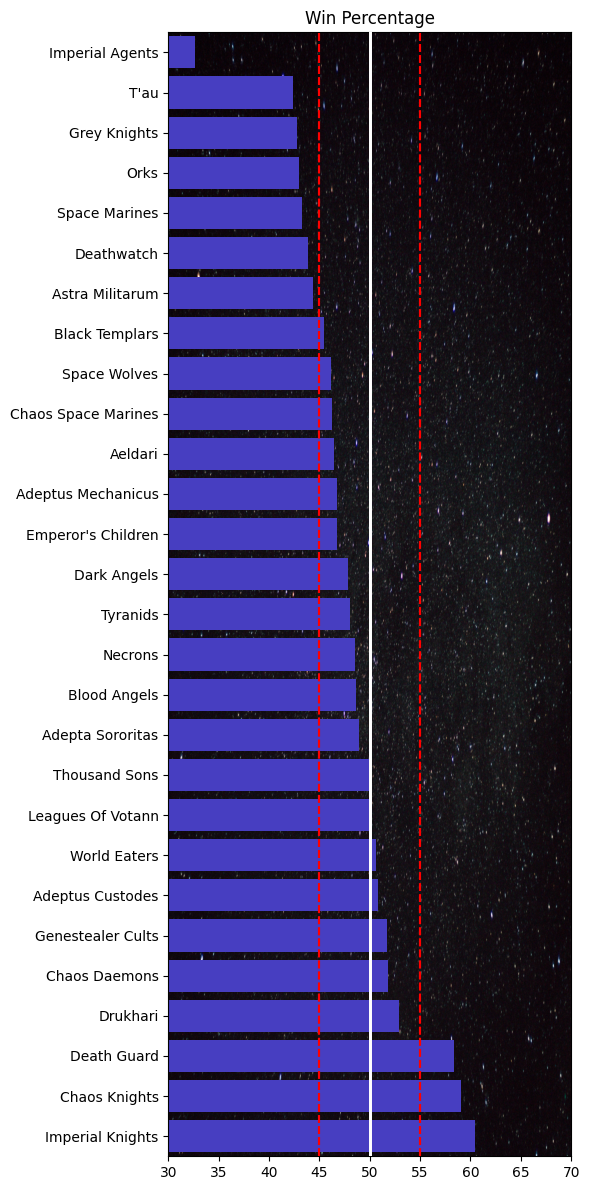

In [254]:
# Create sorted table and image for plt
winPCT_faction_df_sorted = winPCT_faction_df.sort_values(by="Real Win %", ascending=False)

fig, ax = plt.subplots(figsize=(6, 12))


# Base plot
sns.barplot(data=winPCT_faction_df_sorted, y="Faction", x="Real Win %", color="#54b7fb")
ax.imshow(bg_img, aspect='auto', extent=[30, 70, -0.5, len(winPCT_faction_df_sorted)-0.5], zorder=0)
sns.barplot(
    data=winPCT_faction_df_sorted,
    y="Faction",
    x="Real Win %",
    color="#3428d7",
    ax=ax,
    zorder=2  # draw on top
)

# Modifying plot aesthetics

plt.title("Win Percentage")
plt.xlabel("")
plt.ylabel("")
plt.xlim(30,70)
ax.imshow(bg_img, aspect='auto', extent=[30, 70, -0.5, len(winPCT_faction_df_sorted)-0.5], zorder=0)


# Adding lines at 50% for balanced and 45% and 55% for factions outside of the balance teams target zone
ax.axvline(x=50, color="white", linewidth=2, zorder=3)
ax.axvline(x=55, color="red", linestyle="--", linewidth=1.5, zorder=3)
ax.axvline(x=45, color="red", linestyle="--", linewidth=1.5, zorder=3)

ax.axvline(x=50, color="white", linewidth=2, zorder=3)
ax.axvline(x=55, color="red", linestyle="--", linewidth=1.5, zorder=3)
ax.axvline(x=45, color="red", linestyle="--", linewidth=1.5, zorder=3)

# Show the plot
plt.tight_layout()
plt.show()

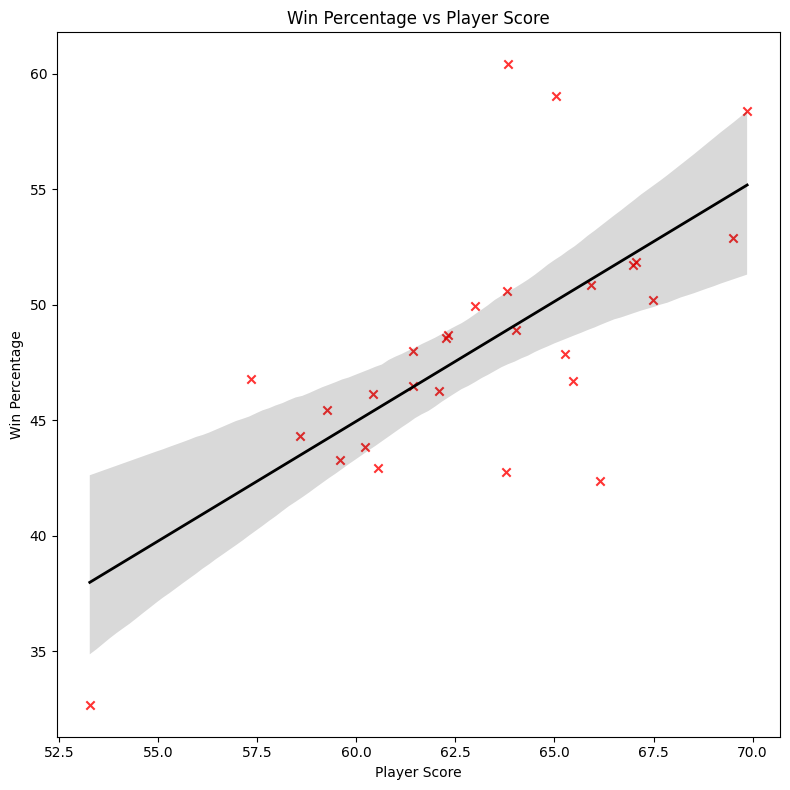

In [ ]:
# Scatter plot with regression line for Player Score vs Real Win %
plt.figure(figsize=(8, 8))

sns.regplot(
    data=winPCT_faction_df,
    x="VP",
    y="Real Win %",
    marker="x", 
    scatter_kws={"color": "red"},
    line_kws={"color": "black", "linewidth": 2},
)

plt.title("Win Percentage vs Player Total Score")
plt.xlabel("Player Score")
plt.ylabel("Win Percentage")
plt.tight_layout()
plt.show()

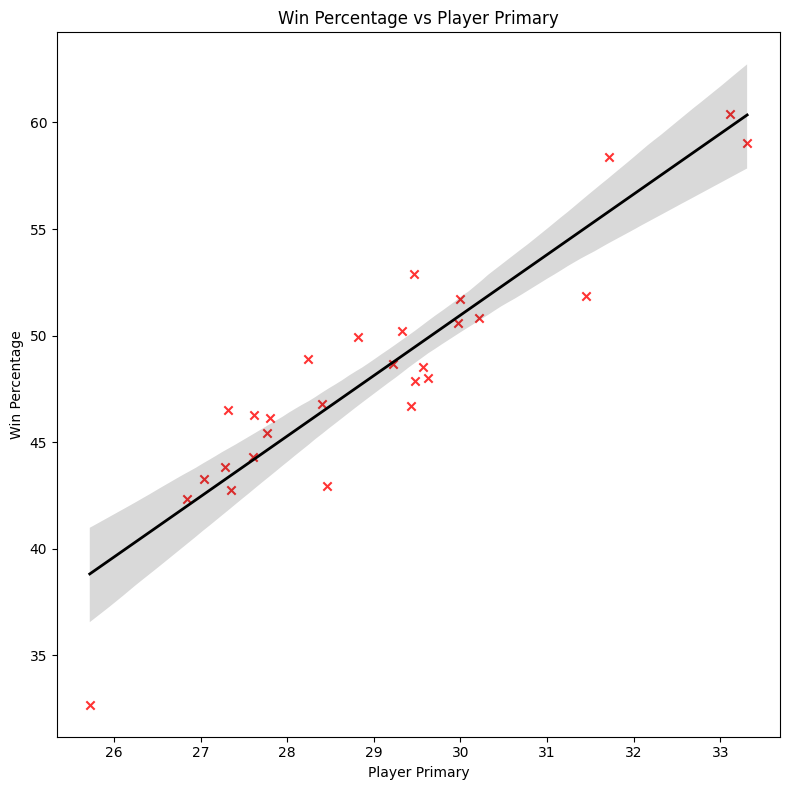

In [ ]:
# Scatter plot with regression line for Player Primary vs Win Percentage
plt.figure(figsize=(8, 8))

sns.regplot(
    data=scorewin,
    x="Player Primary",
    y="Win Percentage",
    marker="x", 
    scatter_kws={"color": "red"},
    line_kws={"color": "black", "linewidth": 2},
)

plt.title("Win Percentage vs Player Primary")
plt.xlabel("Player Primary")
plt.ylabel("Win Percentage")
plt.tight_layout()
plt.show()

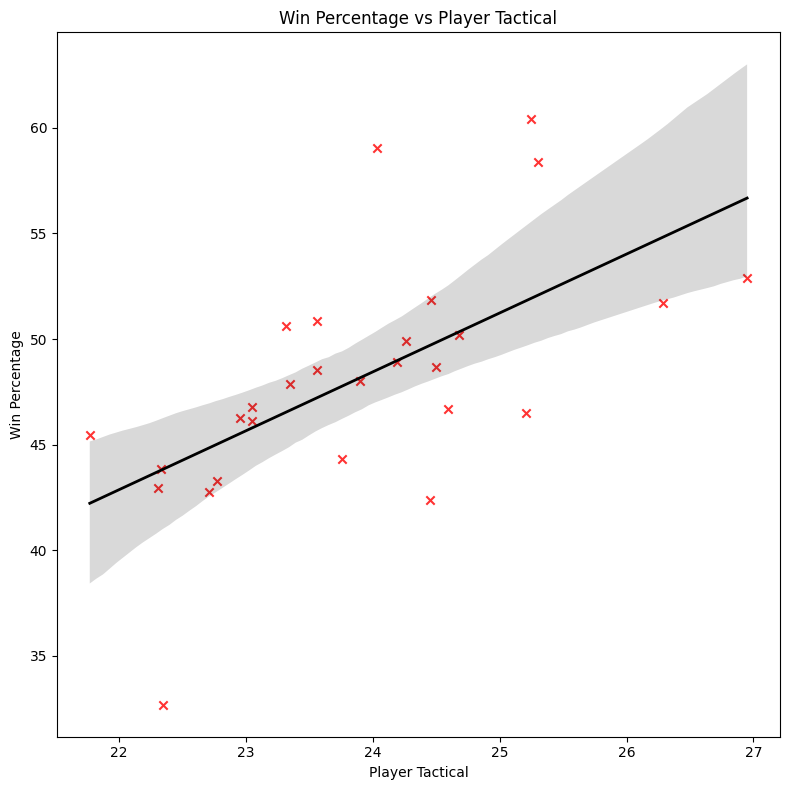

In [ ]:
# Scatter plot with regression line for Player Tactical vs Win Percentage
plt.figure(figsize=(8, 8))

sns.regplot(
    data=scorewin,
    x="Player Tactical",
    y="Win Percentage",
    marker="x", 
    scatter_kws={"color": "red"},
    line_kws={"color": "black", "linewidth": 2},
)

plt.title("Win Percentage vs Player Tactical")
plt.xlabel("Player Tactical")
plt.ylabel("Win Percentage")
plt.tight_layout()
plt.show()

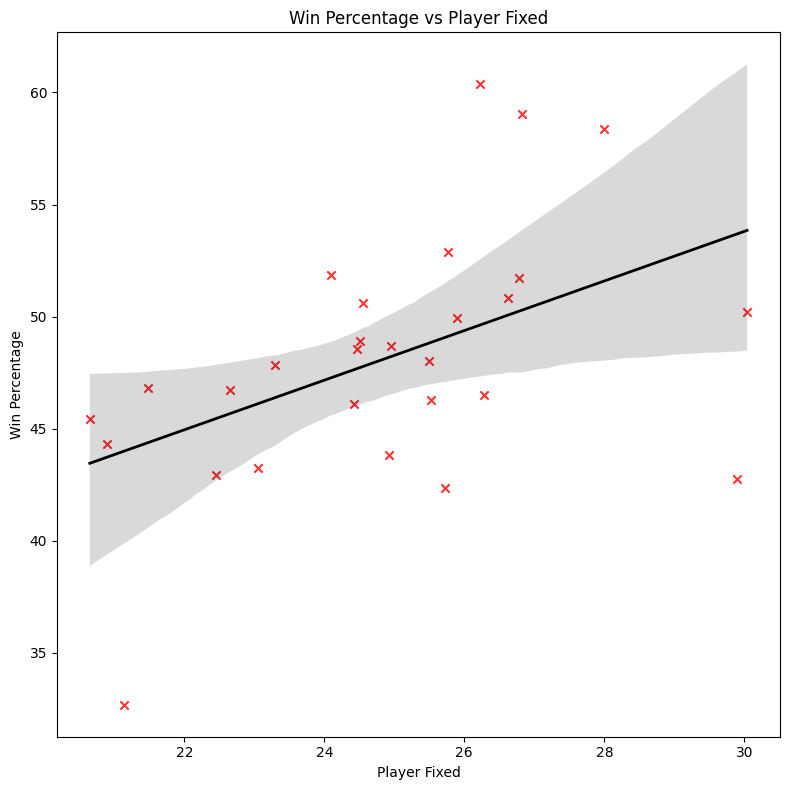

In [125]:
# Scatter plot with regression line for Player Fixed vs Win Percentage
plt.figure(figsize=(8, 8))

sns.regplot(
    data=scorewin,
    x="Player Fixed",
    y="Win Percentage",
    marker="x", 
    scatter_kws={"color": "red"},
    line_kws={"color": "black", "linewidth": 2},
)

plt.title("Win Percentage vs Player Fixed")
plt.xlabel("Player Fixed")
plt.ylabel("Win Percentage")
plt.tight_layout()
plt.show()

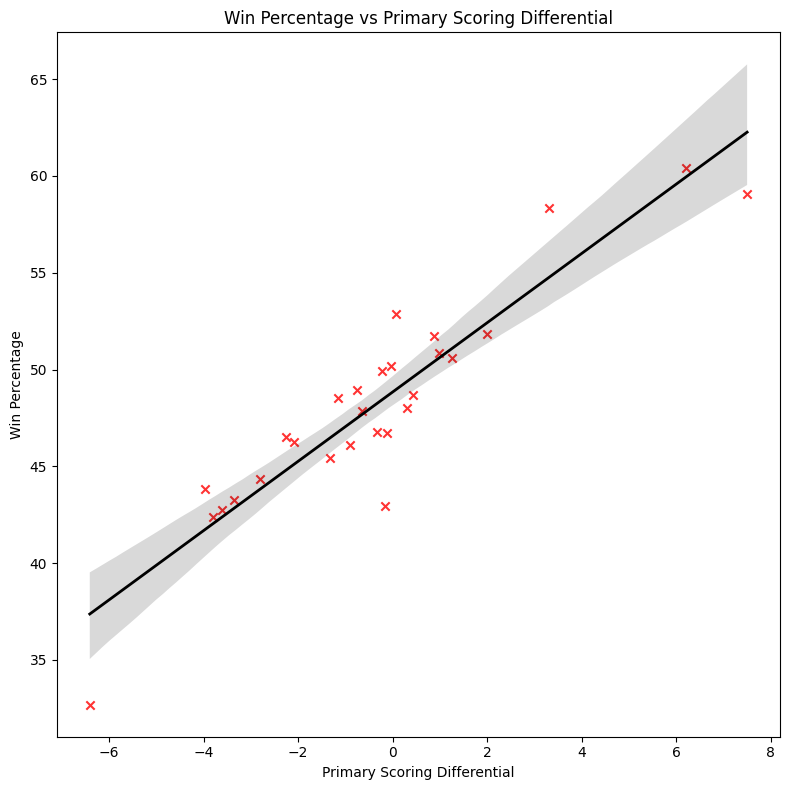

In [228]:
# Scatter plot with regression line for Player Fixed vs Win Percentage
plt.figure(figsize=(8, 8))

sns.regplot(
    data=scorewin,
    x="Primary Scoring Differential",
    y="Win Percentage",
    marker="x", 
    scatter_kws={"color": "red"},
    line_kws={"color": "black", "linewidth": 2},
)

plt.title("Win Percentage vs Primary Scoring Differential")
plt.xlabel("Primary Scoring Differential")
plt.ylabel("Win Percentage")
plt.tight_layout()
plt.show()

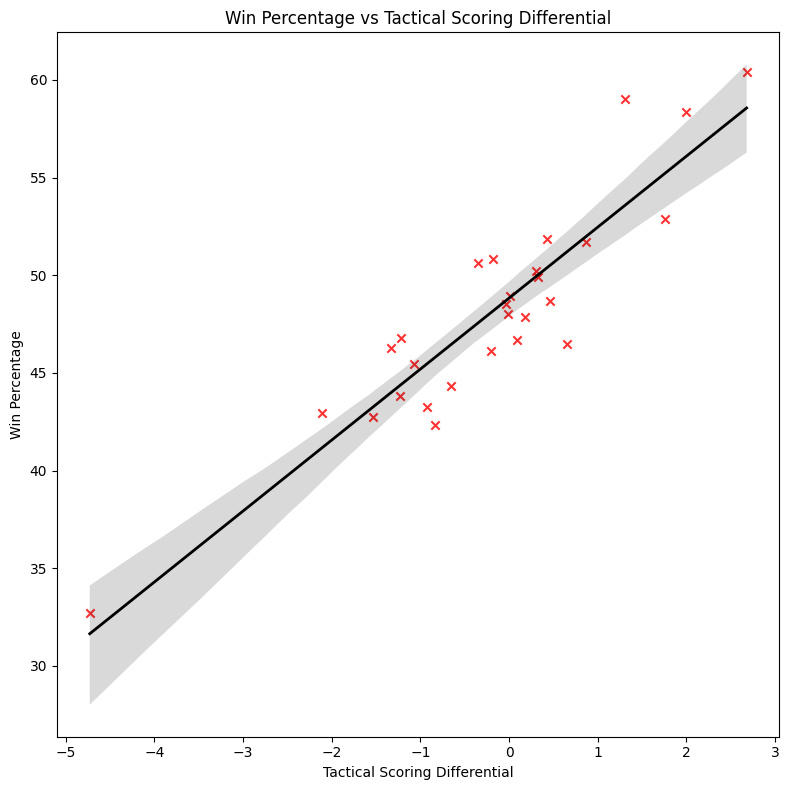

In [230]:
# Scatter plot with regression line for Tactical Diff vs Win Percentage
plt.figure(figsize=(8, 8))

sns.regplot(
    data=scorewin,
    x="Tactical Scoring Differential",
    y="Win Percentage",
    marker="x", 
    scatter_kws={"color": "red"},
    line_kws={"color": "black", "linewidth": 2},
)

plt.title("Win Percentage vs Tactical Scoring Differential")
plt.xlabel("Tactical Scoring Differential")
plt.ylabel("Win Percentage")
plt.tight_layout()
plt.show()

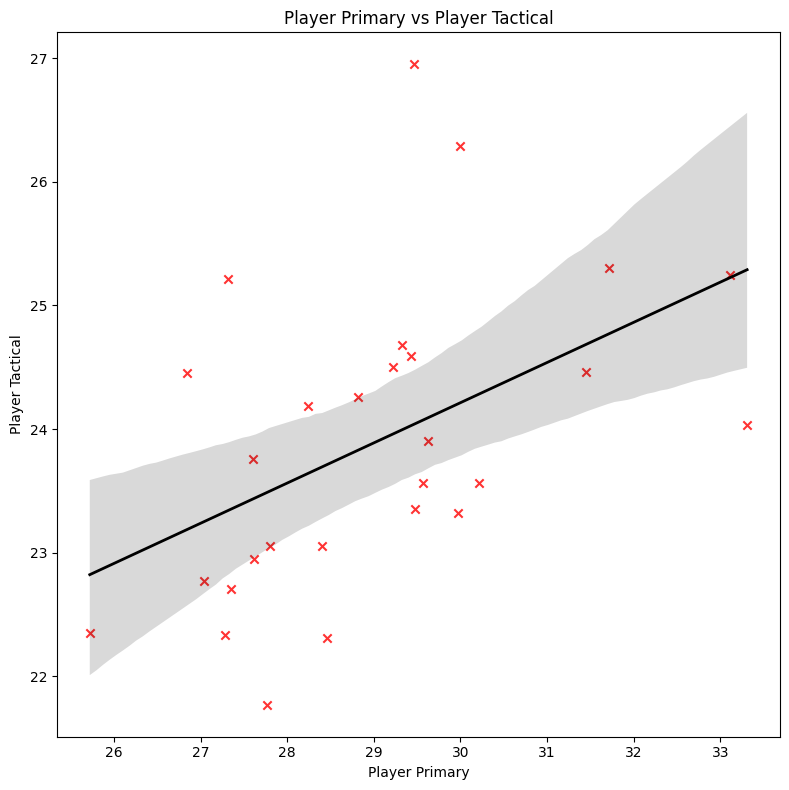

In [231]:
# Scatter plot with regression line for Tactical Player primary vs player tactical to see if there is a relationship
plt.figure(figsize=(8, 8))

sns.regplot(
    data=scorewin,
    x="Player Primary",
    y="Player Tactical",
    marker="x", 
    scatter_kws={"color": "red"},
    line_kws={"color": "black", "linewidth": 2},
)

plt.title("Player Primary vs Player Tactical")
plt.xlabel("Player Primary")
plt.ylabel("Player Tactical")
plt.tight_layout()
plt.show()

The scatter plots show that, not unexpectedly, that higher VP, tactical and primary differential. However there is a much weaker relationship between player tactical and primary scoring. Armies which on average delivered higher primary scoring did not always deliver higher tactical scoring. This may be due to diffing play-styles of different armies.

The relationships between scoring and win percentage allow for regression analyis of these factors, which will be carried out below. This dataset is not ideal due to its low sample count, and since the data only represents averages across varied player skill level, terrain types, and varied army and detatchment composition. Hoewever, for working on a proof of concept the data will suffice, although the predictions generated from it will only strictly apply at the higher average army level as this is the level the data was taken from.

# Regression Analysis

Initally using a OLS model with multiple terms included allows us to judge the significance of each variable. The differential scores are inferred from player and opponent scores, so there is likely to be a degree of co-liniarty in this first analysis. 

Using statsmodel and OLS method

In [135]:
#Quick rough first regression analysis to judge variables and significance

# Dependent variable
y = scorewin['Win Percentage']

# Independent variables
X = scorewin[['Player Primary', 'Player Tactical', 'Player Fixed', 'Primary Scoring Differential', 'Tactical Scoring Differential', 'Fixed Scoring Differential']]
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Win Percentage   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     107.6
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           1.16e-14
Time:                        14:06:55   Log-Likelihood:                -39.141
No. Observations:                  28   AIC:                             92.28
Df Residuals:                      21   BIC:                             101.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [ ]:
#Dropping out variables with low p-values (p<0.05), and probable co-linarity 

# Dependent variable
y = scorewin['Win Percentage']

# Independent variables
X = scorewin[['Primary Scoring Differential', 'Tactical Scoring Differential']]
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Win Percentage   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     292.3
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           4.58e-18
Time:                        14:08:03   Log-Likelihood:                -42.830
No. Observations:                  28   AIC:                             91.66
Df Residuals:                      25   BIC:                             95.66
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

The R-squared for the model is 0.959 meaning that the model explains 96% of the variation observed in the win rate, and is a good fit for the data. The equation for the model could be used to predict the winrate of a faction based on averaged primary and tactical scoring differentials. 

Using a machine learning method - scikit-learn

In [210]:
# Variables
X = scorewin[['Primary Scoring Differential', 'Tactical Scoring Differential']]
y = scorewin['Win Percentage'] 

# Splitting the data into training and testing sets to allow predictions of the model to be tested against remaining data, although this does lead to small training set size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
skmodel = LinearRegression()
skmodel.fit(X_train, y_train)

# Coefficients and intercept 
print("Intercept:", skmodel.intercept_)
print("Coefficients:", skmodel.coef_)

Intercept: 48.869297417191085
Coefficients: [1.25874134 1.70499621]


In [211]:
# Make predictions on the test set
y_pred = skmodel.predict(X_test)

# View predicted vs actual
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

print(predictions_df)

# Optional: Model evaluation
print("R² score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

   Actual  Predicted
0   46.28  43.970883
1   49.93  49.155023
2   59.05  60.543403
3   42.93  45.057769
4   48.92  47.929704
5   43.83  41.762362
R² score: 0.8952270368582561
Mean Squared Error: 2.9910131501531416


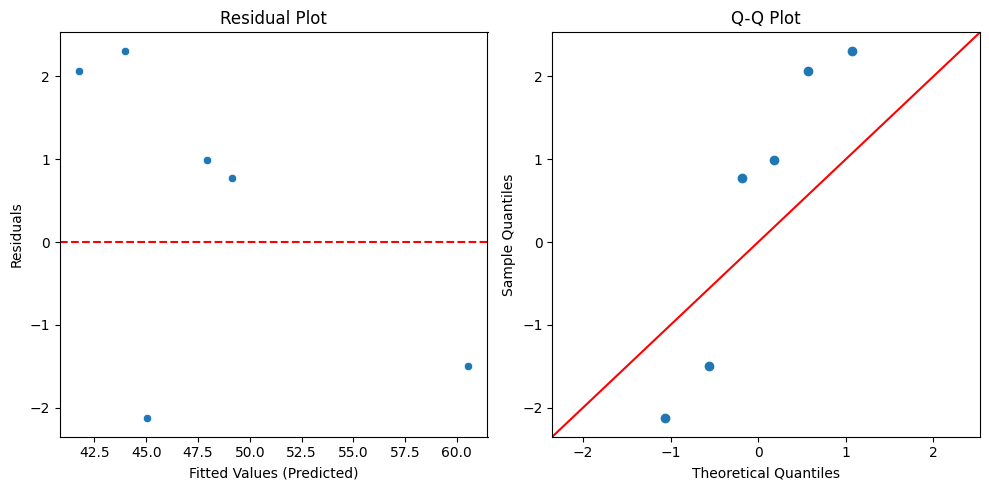

In [212]:
# Get predictions and residuals for checking model meets assumptions
y_pred = skmodel.predict(X_test)
residuals = y_test - y_pred
fitted = y_pred 


plt.figure(figsize=(10, 5))

#Residual Plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted)')
plt.ylabel('Residuals')
plt.title('Residual Plot')

#Q-Q Plot
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='45', ax=plt.gca())
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [243]:
#Testing to see if we can pass a single one-off result for prediction of win percentage 
singlePredict = pd.DataFrame([{'Primary Scoring Differential':10, 'Tactical Scoring Differential':5}])

#print(model.predict(np.array([[10, 7]]))) # this works but gives warnings due to lack of column names

print(skmodel.predict(singlePredict)) 

[69.98169188]


Trying PyTorch for a different machine learning model

In [245]:
# Features and target
X = scorewin[['Primary Scoring Differential', 'Tactical Scoring Differential']].values
y = scorewin['Win Percentage'].values

# Splitting the data into training and testing sets, again does result in a relatively small training set size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale inputs for better training stability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define model
ptmodel = nn.Linear(in_features=2, out_features=1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ptmodel.parameters(), lr=0.1)

# To train the model
epochs = 2000
for epoch in range(epochs):
    ptmodel.train()
    optimizer.zero_grad()
    output = ptmodel(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Printing Loxx to track training progress
    if epoch % 250 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Predict on test set
ptmodel.eval()
with torch.no_grad():
    predictions = ptmodel(X_test_tensor).numpy()

# Compare predictions to actual
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.flatten()
})
print(results)

Epoch 0, Loss: 2311.4475
Epoch 250, Loss: 667.7642
Epoch 500, Loss: 130.8318
Epoch 750, Loss: 16.1707
Epoch 1000, Loss: 1.9746
Epoch 1250, Loss: 1.0169
Epoch 1500, Loss: 0.9833
Epoch 1750, Loss: 0.9827
   Actual  Predicted
0   46.28  43.970745
1   49.93  49.154884
2   59.05  60.543262
3   42.93  45.057629
4   48.92  47.929565
5   43.83  41.762222


In [246]:
# Testing this on novel data

new_input = np.array([[10, 5]])
new_input_scaled = scaler.transform(new_input)
new_tensor = torch.tensor(new_input_scaled, dtype=torch.float32)

with torch.no_grad():
    predicted_winrate = ptmodel(new_tensor).item()

print("Predicted Win Percentage:", predicted_winrate)

Predicted Win Percentage: 69.98155212402344


Testing adding in total player VP to see how it effects the model

In [241]:
# Features and target
X = scorewin[['VP', 'Primary Scoring Differential', 'Tactical Scoring Differential']].values
y = scorewin['Win Percentage'].values

# Splitting the data into training and testing sets, again does result in a relatively small training set size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale inputs for better training stability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define model
ptmodel = nn.Linear(in_features=3, out_features=1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ptmodel.parameters(), lr=0.1)

# To train the model
epochs = 2000
for epoch in range(epochs):
    ptmodel.train()
    optimizer.zero_grad()
    output = ptmodel(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Printing Loxx to track training progress
    if epoch % 250 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Predict on test set
ptmodel.eval()
with torch.no_grad():
    predictions = ptmodel(X_test_tensor).numpy()

# Compare predictions to actual
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.flatten()
})
print(results)

Epoch 0, Loss: 2316.5854
Epoch 250, Loss: 671.2307
Epoch 500, Loss: 131.8733
Epoch 750, Loss: 16.2501
Epoch 1000, Loss: 1.8543
Epoch 1250, Loss: 0.8759
Epoch 1500, Loss: 0.8413
Epoch 1750, Loss: 0.8407
   Actual  Predicted
0   46.28  44.164536
1   49.93  48.988583
2   59.05  60.567772
3   42.93  45.353394
4   48.92  47.993271
5   43.83  41.611259


In [242]:
# Testing this on novel data

new_input = np.array([[70, 2, 1]])
new_input_scaled = scaler.transform(new_input)
new_tensor = torch.tensor(new_input_scaled, dtype=torch.float32)

with torch.no_grad():
    predicted_winrate = ptmodel(new_tensor).item()

print("Predicted Win Percentage:", predicted_winrate)

Predicted Win Percentage: 53.73788070678711


When predicting a faction winrate from novel data with a primary and tactical scoring diff of 2 and 1 respectively both the scikit-learn and PyTorch models predict a winrate of 53.09. When the prediction is carried out using differentials higher than that observed in our training data (10 and 5) the similarity between the two models remains, with both predicting an average win rate for a faction of 69.981%. 

Adding total player score (VP) to the Pytorch model does slightly decrease the loss observed at the end of training from 0.9827 to 0.8407 meaning that in theory this model should be more accurate. 

In [253]:
# As one xlsx file with multiple sheets
with pd.ExcelWriter('combined_GH_data.xlsx', engine='xlsxwriter') as writer:
    scorewin.to_excel(writer, sheet_name='ScoreWin', index=False)
    scoring_faction_df.to_excel(writer, sheet_name='Scoring', index=False)
    winPCT_faction_df.to_excel(writer, sheet_name='WinPCT', index=False)
    mission_scoring_df.to_excel(writer, sheet_name='mission_scoring_df', index=False)

In [ ]:
# Create dictionary of mission-specific DataFrames for splitting
mission_dfs = {}
for mission in mission_scoring_df['Mission'].unique():
    # Create valid sheet name by removing/cleaning characters
    safe_name = mission.replace(" ", "_").replace("/", "_").replace("-", "_")
    mission_dfs[f"{safe_name}_df"] = mission_scoring_df[mission_scoring_df['Mission'] == mission].copy()

# Export to Excel workbook with multiple sheets
with pd.ExcelWriter("missions_by_sheet.xlsx", engine='xlsxwriter') as writer:
    for sheet_name, df in mission_dfs.items():
        # Optional: truncate sheet name to 31 characters (Excel limit)
        safe_sheet = sheet_name[:31]
        df.to_excel(writer, sheet_name=safe_sheet, index=False)